In [ ]:
from pathlib import Path

# Créer le dossier 'content' si besoin
path_dir = Path('content')
path_dir.mkdir(parents=True, exist_ok=True)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations

def unpack_params(params, shapes, dtypes):
    """Unpack params back into matrices with given shapes and dtypes."""
    idx = 0
    matrices = []
    for shape, dtype in zip(shapes, dtypes):
        size = np.prod(shape)
        values = params[idx:idx + size]
        matrix = values.reshape(shape).astype(dtype)
        matrices.append(matrix)
        idx += size
    return matrices

def TFD1D(freqs1, freqs2): # vectorized
    # Convertir les listes en tableaux numpy
    f1 = np.array(freqs1)
    f2 = np.array(freqs2)
    # Créer une grille de valeurs pour f1 et f2
    F1, F2 = np.meshgrid(f1, f2, indexing='ij')
    # Calculer la matrice TFD directement
    TFD = np.exp(2j * np.pi * F1 * F2)
    return TFD

def sample_uniform_frequencies_1d(n, bound=0.5):
    # Calculer le nombre de points dans chaque dimension
    N = 2 * n + 1
    # Générer une grille uniforme de points entre -0.5 et 0.5
    grid_1d = np.linspace(-bound, bound, N)
    return grid_1d

class Gauss1D():

  def __init__(self, n=0, sigma=1):
    self.n = n
    self.sigma = sigma

    self.g_ = np.array([])
    self.g()

  def fourier(self, w):
    return np.exp(-2 * (w * self.sigma * np.pi)**2)

  def g(self):
    if len(self.g_) == 0:
      freqs = sample_uniform_frequencies_1d(self.n)
      self.g_ = np.array([self.fourier(f) for f in freqs])
    return self.g_

  def compute(self, t):
    t_array = np.array(t)
    return (1/(self.sigma*np.sqrt(2*np.pi))) * np.exp(-t_array**2/(2* self.sigma**2))

  def computeK(self, t):
    t = np.array(t)
    freqs = sample_uniform_frequencies_1d(self.n)
    if len(t.shape) == 0:
        return np.sum(np.abs(self.g())**2 * np.exp(2j * np.pi * freqs * t))
    V = np.exp(2j * np.pi * np.outer(freqs, t))
    return np.sum(np.abs(self.g())**2 * V.T, axis=1).reshape(t.shape)

  def computeK_p(self, t):
      t = np.array(t)
      freqs = sample_uniform_frequencies_1d(self.n)
      if len(t.shape) == 0:
          return np.sum(2j * np.pi * freqs * np.abs(self.g())**2 * np.exp(2j * np.pi * freqs * t))
      V = np.exp(2j * np.pi * np.outer(freqs, t))
      return np.sum(np.abs(self.g())**2 * (2j * np.pi * freqs) * V.T, axis=1).reshape(t.shape)

  def computeK_pp(self, t):
      t = np.array(t)
      freqs = sample_uniform_frequencies_1d(self.n)
      if len(t.shape) == 0:
          return np.sum((2j * np.pi * freqs)**2 * np.abs(self.g())**2 * np.exp(2j * np.pi * freqs * t))
      V = np.exp(2j * np.pi * np.outer(freqs, t))
      return np.sum(np.abs(self.g())**2 * (2j * np.pi * freqs)**2 * V.T, axis=1).reshape(t.shape)

  def computeK_pp0(self):
      return self.computeK_pp(0)

In [2]:
import numpy as np

def compute_z(a, tau, g, freqs):
    # Calcule la matrice d'exponentielles avec np.outer
    exp_matrix = np.exp(2j * np.pi * np.outer(freqs, tau))  # forme : (len(freqs), len(tau))
    # Effectue le produit matriciel sur la seconde dimension, puis multiplie par g élément par élément
    return g * exp_matrix.dot(a)

def grad_approx_perso(kernel, theta_pred, data_observed, freqs):
    r = len(theta_pred) // 2
    a = theta_pred[:r]
    tau = theta_pred[r:]

    # Construction de la matrice des différences de tau de taille (r, r)
    tau_diff_matrix = tau[:, None] - tau[None, :]

    # Calcul vectorisé des matrices de kernel
    k_matrix = kernel.computeK(tau_diff_matrix)
    kp_matrix = kernel.computeK_p(tau_diff_matrix)

    # Préparation de kernel_g et des données observées
    kernel_g = np.conj(kernel.g()).flatten()
    data_observed = data_observed.flatten()
    freqs = freqs.flatten()

    # Calcul de la matrice d'exponentielles pour le terme en tau
    exp_term = np.exp(-2j * np.pi * np.outer(tau, freqs))

    # Première partie du gradient (associée à a)
    # Pour chaque j : somme_i(a[i]*k_matrix[j,i]) - somme_k(kernel_g[k]*data_observed[k]*exp_term[j,k])
    grad_a = k_matrix.dot(a) - exp_term.dot(kernel_g * data_observed)

    # Seconde partie du gradient (associée à tau)
    # Terme 1 : np.conj(a[j]) * somme_i(a[i]*kp_matrix[j,i]) pour chaque j
    term1 = np.conj(a) * (kp_matrix.dot(a))
    # Terme 2 : np.conj(a[j]) * somme_k(kernel_g[k]*data_observed[k]*(-2j*np.pi*freqs[k])*exp_term[j,k])
    Y = -2j * np.pi * freqs * (kernel_g * data_observed)
    term2 = np.conj(a) * (exp_term.dot(Y))

    # On conserve la partie réelle pour le gradient sur tau
    grad_tau = np.real(term1) - np.real(term2)

    # Concatène les deux parties pour former le gradient complet
    return np.concatenate([grad_a, grad_tau])

In [3]:
def min_norm_permuted_theta(theta_est, theta_star):
    """
    Calcule la norme minimale ||theta_est - theta_star_perm|| sur toutes les permutations
    de la partie position de theta_star, en appliquant la même permutation aux amplitudes.

    On suppose que theta est structuré comme suit:
    theta = [a1, a2, ..., a_N, tau1, tau2, ..., tau_N]

    Paramètres:
    - theta_est (numpy array): Estimation du vecteur theta
    - theta_star (numpy array): Vecteur theta "vrai"

    Retourne:
    - float: La norme minimale calculée sur toutes les permutations possibles
    """
    # Nombre d'éléments par bloc (amplitudes et positions)
    r = len(theta_est) // 2

    # Séparation en amplitudes et positions pour theta_est et theta_star
    a_est, tau_est = theta_est[:r], theta_est[r:]
    a_star, tau_star = theta_star[:r], theta_star[r:]

    min_error = float('inf')

    # Considérer toutes les permutations d'indices pour la partie positions
    for perm in permutations(range(r)):
        # Appliquer la permutation sur les positions et les amplitudes associées
        a_star_perm = a_star[list(perm)]
        tau_star_perm = tau_star[list(perm)]
        # Reconstruire le vecteur theta après permutation
        theta_star_perm = np.concatenate([a_star_perm, tau_star_perm])
        error = np.linalg.norm(theta_est - theta_star_perm)
        min_error = min(min_error, error)

    return min_error


def min_norm_permuted_tau(theta_est, theta_star):
    """
    Calcule la norme minimale ||tau_est - tau_star_perm|| sur toutes les permutations
    de la partie position de theta_star, en ignorant les amplitudes.

    On suppose que theta est structuré comme suit:
    theta = [a1, a2, ..., a_N, tau1, tau2, ..., tau_N]

    Paramètres:
    - theta_est (numpy array): Estimation du vecteur theta
    - theta_star (numpy array): Vecteur theta "vrai"

    Retourne:
    - float: La norme minimale calculée sur toutes les permutations possibles des positions
    """
    # Nombre d'éléments de positions (tau)
    r = len(theta_est) // 2

    # Extraire les positions (tau) pour theta_est et theta_star
    tau_est = theta_est[r:]
    tau_star = theta_star[r:]

    min_error = float('inf')

    # Considérer toutes les permutations des indices pour la partie positions
    for perm in permutations(range(r)):
        tau_star_perm = tau_star[list(perm)]
        error = np.linalg.norm(tau_est - tau_star_perm)
        min_error = min(min_error, error)

    return min_error

In [4]:
def add_noise(y_current, snr_db):
    # Calcul de la puissance du signal
    signal_power = np.mean(np.abs(y_current)**2)

    # Conversion du SNR de dB à linéaire
    snr_linear = 10**(snr_db/10)

    # Calcul de la puissance du bruit
    noise_power = signal_power / snr_linear

    # Génération du bruit (pour un signal complexe)
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_current.shape) + 1j*np.random.randn(*y_current.shape))

    # Signal bruité
    y_noisy = y_current + noise
    return y_noisy

In [5]:
# Define the Gaussian kernel in spatial domain
def gauss1d(x, sigma, tau):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(- (x - tau) ** 2 / (2 * sigma ** 2))

def compute_theta_star_sequence(time_steps, min_distance=5.0, threshold_ratio=1.5):
    theta_star_sequence = []
    for t in range(time_steps):
        # Time variable (no scaling factor)
        time_var = t

        # Define deterministic functions for a_star and tau_star
        # Amplitudes vary sinusoidally and positions move linearly
        a_star = np.array([
            0.3 + 0.2 * np.sin(0.2 * time_var),
            0.3 + 0.2 * np.sin(0.2 * time_var + 2 * np.pi / 3),
            0.3 + 0.2 * np.sin(0.2 * time_var + 4 * np.pi / 3)
        ])
        # Ensure amplitudes are non-negative
        a_star = np.clip(a_star, 0, None)
        # Normalize amplitudes to sum to 1
        a_star /= np.sum(a_star)

        # Enforce threshold on a_max / a_min ratio
        a_max = np.max(a_star)
        a_min = np.min(a_star)

        if a_max / a_min < threshold_ratio:
            # Adjust the minimum value to ensure ratio meets the threshold
            target_min = a_max / threshold_ratio
            scale_factor = (1 - target_min) / (np.sum(a_star) - a_min)
            a_star = np.clip(a_star * scale_factor, target_min, None)
            # Normalize again to sum to 1
            a_star /= np.sum(a_star)


        # Initial tau_star with linear movement
        tau_star = np.array([
            -6 + 0.1 * time_var,
            -3 + 0.05 * time_var,
             5 - 0.08 * time_var
        ])


        for i in range(len(tau_star) - 1):
            for j in range(i + 1, len(tau_star)):
                # Calculate the distance between two points
                distance = abs(tau_star[i] - tau_star[j])
                if distance < min_distance:
                    # Adjust positions
                    adjustment = (min_distance - distance) / 2
                    tau_star[i] -= adjustment
                    tau_star[j] += adjustment



        # Concatenate to form theta_star
        theta_star = np.concatenate((a_star, tau_star))
        theta_star_sequence.append(theta_star)
    return theta_star_sequence

# Compute the sequence of theta_star
# Spatial grid for plotting densities
x = np.linspace(-10, 10, 500)
time_steps = 150  # Total number of time steps

n=16
N=2*n+1
freqs = sample_uniform_frequencies_1d(n)
sigma = 1
kernel = Gauss1D(n, sigma)
g_star = kernel.fourier(freqs) + 0j

theta_star_sequence = compute_theta_star_sequence(time_steps)
r = len(theta_star_sequence[0]) // 2


S_err = lambda theta : np.max([np.abs(theta[:r] - theta_star[:r])/np.abs(theta_star[:r]), np.sqrt(np.abs(kernel.computeK_pp0()))*np.abs(theta[r:] - theta_star[r:])])

F_second = np.abs(kernel.computeK_pp0())
def P_k(a):
  return np.diag(np.concatenate( [np.ones(len(a)), 1/F_second * (np.abs(a)**-2)] ))

In [6]:
def compute_crb(theta_star, snr_db):
    """
    Calcule la borne de Cramér-Rao pour le vecteur de paramètres theta_star
    avec le SNR en dB donné.

    Modèle :
      z[k] = sum_{j=0}^{r-1} a_star[j] * g_star[k] * exp(2πi * tau_star[j] * freqs[k])

    On suppose que les paramètres theta_star = [a_0,...,a_{r-1}, tau_0,...,tau_{r-1}]
    sont réels. Le bruit est supposé gaussien complexe propre de variance sigma^2.

    Paramètres :
      theta_star : np.array
          Vecteur de paramètres vrai de longueur 2*r.
      snr_db : float
          Rapport signal sur bruit en dB.

    Renvoie :
      crb_norm : float
          Borne inférieure sur la norme de l'erreur d'estimation (sqrt(trace(CRB_matrix))).
      CRB_matrix : np.array
          Matrice CRB complète (inverse de la FIM).
    """
    # Extraction des paramètres
    a_star = theta_star[:r]
    tau_star = theta_star[r:]

    # Calcul du signal sans bruit
    f = compute_z(a_star, tau_star, g_star, freqs)
    N = len(freqs)

    # Puissance moyenne du signal
    signal_power = np.mean(np.abs(f)**2)

    # Conversion du SNR de dB en linéaire et calcul de sigma^2
    snr_linear = 10**(snr_db/10)
    sigma2 = signal_power / snr_linear

    # Construction de la matrice Jacobienne J de dimension (N, 2r)
    J = np.zeros((N, 2*r), dtype=complex)
    for k in range(N):
        for j in range(r):
            # Dérivée par rapport à a_j
            J[k, j] = g_star[k] * np.exp(2j * np.pi * tau_star[j] * freqs[k])
            # Dérivée par rapport à tau_j
            J[k, r+j] = a_star[j] * g_star[k] * (2j * np.pi * freqs[k]) * np.exp(2j * np.pi * tau_star[j] * freqs[k])

    # Calcul de la matrice d'information de Fisher (FIM)
    FIM = (2/sigma2) * np.real(np.conjugate(J).T @ J)

    try:
        # Calcul de la CRB (matrice inverse de la FIM)
        CRB_matrix = np.linalg.inv(FIM) # attention pinv ou inv selon le comportement que l'on souhaite
        # Borne inférieure sur l'erreur en norme (erreur euclidienne minimale)
        crb_norm = np.sqrt(np.trace(CRB_matrix))
    except np.linalg.LinAlgError: # si np.inv alors ne gère pas les matrices singluières
        # Si la matrice est singulière, mettre NaN
        CRB_matrix = np.full_like(FIM, np.nan)  # Matrice remplie de NaN
        crb_norm = np.nan

    return crb_norm, CRB_matrix


def compute_crb_values(theta_star_sequence, snr_db):
    """
    Calcule les valeurs de la borne de Cramér-Rao pour chaque pas de temps
    d'une séquence de vecteurs de paramètres vrais.

    Paramètres :
      theta_star_sequence : list ou np.array
          Séquence (de longueur T) des vecteurs de paramètres vrais (chacun de longueur 2*r).
      snr_db : float
          SNR en dB.

    Renvoie :
      crb_vals : np.array
          Tableau des valeurs CRB (borne sur l'erreur en norme) pour chaque pas de temps.
    """
    time_steps = len(theta_star_sequence)
    crb_vals = np.zeros(time_steps)
    for t in range(time_steps):
        crb_norm, _ = compute_crb(theta_star_sequence[t], snr_db)
        crb_vals[t] = crb_norm
    return crb_vals

######################
# Uniquement tau
######################

def compute_crb_tau(theta_star, snr_db):
    """
    Calcule la borne de Cramér-Rao pour la partie position (tau) du vecteur de paramètres theta_star
    avec le SNR en dB donné, en ignorant les amplitudes.

    Modèle :
      z[k] = sum_{j=0}^{r-1} a_star[j] * g_star[k] * exp(2πi * tau_star[j] * freqs[k])

    On suppose que les paramètres theta_star = [a_0,...,a_{r-1}, tau_0,...,tau_{r-1}]
    sont réels, et que les fonctions/variables g_star, freqs et compute_z sont définies ailleurs.

    Paramètres :
      theta_star : np.array
          Vecteur de paramètres vrai de longueur 2*r (les amplitudes puis les positions).
      snr_db : float
          Rapport signal sur bruit en dB.

    Renvoie :
      crb_tau_norm : float
          Borne inférieure sur la norme de l'erreur d'estimation pour les positions
          (sqrt(trace(CRB_tau_matrix))).
      CRB_tau_matrix : np.array
          Matrice CRB pour les positions (inverse de la FIM partielle).
    """
    # Nombre d'éléments par bloc
    r = len(theta_star) // 2
    a_star = theta_star[:r]
    tau_star = theta_star[r:]

    # Calcul du signal sans bruit pour obtenir la puissance du signal
    # compute_z doit être défini dans votre environnement et dépend de g_star et freqs.
    f = compute_z(a_star, tau_star, g_star, freqs)
    N = len(freqs)

    # Puissance moyenne du signal et calcul de sigma^2 à partir du SNR
    signal_power = np.mean(np.abs(f)**2)
    snr_linear = 10**(snr_db / 10)
    sigma2 = signal_power / snr_linear

    # Construction de la matrice Jacobienne pour les paramètres tau seulement.
    J_tau = np.zeros((N, r), dtype=complex)
    for k in range(N):
        for j in range(r):
            J_tau[k, j] = a_star[j] * g_star[k] * (2 * 1j * np.pi * freqs[k]) * \
                          np.exp(2 * 1j * np.pi * tau_star[j] * freqs[k])

    # Calcul de la FIM pour tau uniquement.
    FIM_tau = (2 / sigma2) * np.real(np.conjugate(J_tau).T @ J_tau)

    try:
        CRB_tau_matrix = np.linalg.inv(FIM_tau)
        crb_tau_norm = np.sqrt(np.trace(CRB_tau_matrix))
    except np.linalg.LinAlgError:
        CRB_tau_matrix = np.full_like(FIM_tau, np.nan)
        crb_tau_norm = np.nan

    return crb_tau_norm, CRB_tau_matrix


def compute_crb_tau_values(theta_star_sequence, snr_db):
    """
    Calcule la borne de Cramér-Rao pour la partie position (tau) pour chaque
    vecteur de paramètres d'une séquence.

    Paramètres :
      theta_star_sequence : list ou np.array
          Séquence (de longueur T) des vecteurs de paramètres vrais (chacun de longueur 2*r).
      snr_db : float
          Rapport signal sur bruit en dB.

    Renvoie :
      crb_tau_vals : np.array
          Tableau des valeurs CRB pour les positions (borne sur l'erreur en norme)
          pour chaque pas de temps.
    """
    time_steps = len(theta_star_sequence)
    crb_tau_vals = np.zeros(time_steps)
    for t in range(time_steps):
        crb_tau_norm, _ = compute_crb_tau(theta_star_sequence[t], snr_db)
        crb_tau_vals[t] = crb_tau_norm
    return crb_tau_vals

In [7]:
# Loss function
def MSE_loss(params, y_current):
    shapes = [(r), (r)]  # Add dtype if needed
    dtypes = [complex, complex]
    a, tau = unpack_params(params, shapes, dtypes)
    z = compute_z(a, tau, g_star, freqs).reshape(-1,1)
    return 0.5 * np.linalg.norm(y_current - z) ** 2

# Preconditioned gradient descent function
def preconditioned_gradient_descent(loss_func, initial_point, y_current, learning_rate=0.01, momentum=0.9, max_iters=200):
    point = np.array(initial_point, dtype=float)
    velocity = np.zeros_like(point)
    loss_values = []
    for i in range(max_iters):
        gradient = grad_approx_perso(kernel, point, y_current, freqs).real
        a = point[:r]
        velocity = momentum * velocity - learning_rate * P_k(a) @ gradient
        point = point + velocity
        point[:r] = np.abs(point[:r])
        loss = loss_func(point, y_current)
        loss_values.append(loss)
    return point, loss_values

In [10]:
# Nombre de réalisations Monte Carlo et nombre de pas de temps
num_experiments = 10
time_steps = len(theta_star_sequence)  # Nombre de pas de temps
errors_all = np.zeros((num_experiments, time_steps))  # Matrice pour stocker les erreurs

# Paramètres de gradient descent et bruit
learning_rate = 0.1
momentum = 0.2
gradient_steps_per_time = 200
snr_db = 40

# Boucle Monte Carlo pour simuler plusieurs expériences
for exp in range(num_experiments):
    # Réinitialiser l'estimation pour chaque expérience
    theta_est = theta_star_sequence[0] + 0.01 * np.random.randn(2 * r)

    # Pour chaque pas de temps
    for t in range(time_steps):
        # Récupérer les vrais paramètres pour le pas de temps t
        theta_star = theta_star_sequence[t]
        a_star, tau_star = theta_star[:r], theta_star[r:]

        # Calculer l'observation y_current et y_current bruité
        y_current = compute_z(a_star, tau_star, g_star, freqs)
        y_current = add_noise(y_current, snr_db)

        # Effectuer la descente de gradient préconditionnée
        theta_est, loss_values = preconditioned_gradient_descent(
            MSE_loss, theta_est, y_current.reshape(-1, 1),
            learning_rate=learning_rate, momentum=momentum, max_iters=gradient_steps_per_time
        )

        # Calculer et stocker l'erreur (ici, la norme euclidienne)
        #error = min_norm_permuted_theta(theta_est, theta_star)
        error = min_norm_permuted_tau(theta_est, theta_star)
        errors_all[exp, t] = error

# Calcul de l'erreur moyenne et de l'écart-type à chaque pas de temps
mean_errors = np.mean(errors_all, axis=0)[1:]
std_errors = np.std(errors_all, axis=0)[1:]

# Calcul de la CRB pour chaque pas de temps via la fonction compute_crb_values
crb_values = compute_crb_values(theta_star_sequence, snr_db)[1:]

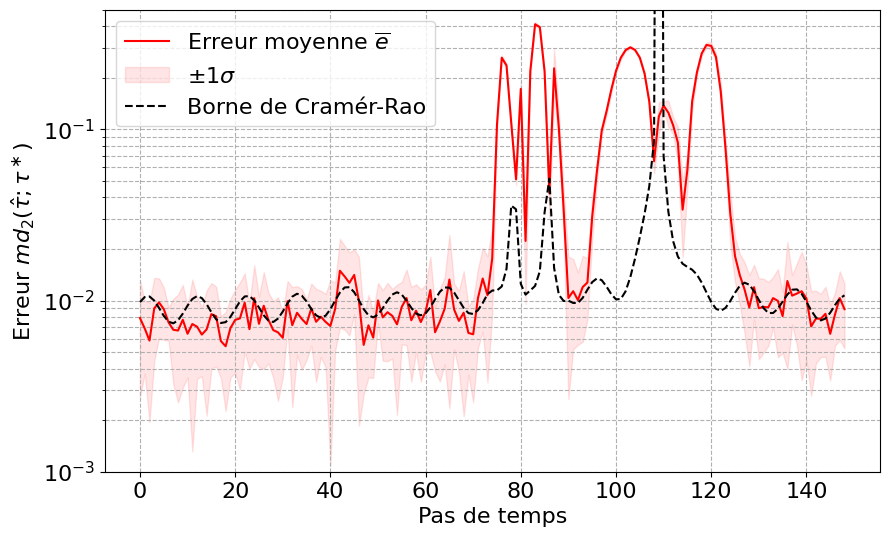

In [ ]:
# Calcul de la CRB pour chaque pas de temps via la fonction compute_crb_values
#crb_values = compute_crb_values(theta_star_sequence, snr_db)[1:]
crb_values = compute_crb_tau_values(theta_star_sequence, snr_db)[1:]

plt.figure(figsize=(10, 6))
plt.plot(mean_errors, label=r"Erreur moyenne $\overline{e}$", color='red')
plt.fill_between(np.arange(time_steps)[:-1],
                 mean_errors - std_errors,
                 mean_errors + std_errors,
                 color='red', alpha=0.1, label=r"$\pm 1 \sigma$")
plt.plot(crb_values, '--', label=r"Borne de Cramér-Rao", color="black")
plt.xlabel(r"Pas de temps", fontsize=16)
#plt.ylabel(r'Erreur $md_2(\hat{\theta};\theta^\ast)$', fontsize=16)
plt.ylabel(r'Erreur $md_2(\hat{\tau};\tau^\ast)$', fontsize=16)
#plt.title(r"Erreur moyenne sur {} expériences vs CRB".format(num_experiments))
plt.yscale("log")  # Échelle logarithmique sur l'axe des ordonnées
plt.ylim(1e-3,0.5)
plt.legend()
plt.grid(True, which="both", linestyle="--")

# Modification
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Save the figure as a PDF
pdf_filename = "content/Erreur_moyenne_DMPGD.pdf"
plt.savefig(pdf_filename, format="pdf")
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Paramètres de simulation
num_experiments = 200
time_steps = len(theta_star_sequence)  # Nombre de pas de temps
gradient_steps_per_time = 40
learning_rate = 0.1
snr_db = 40

threshold = 1e-1       # Seuil pour le taux de décochage

# Valeurs de momentum
momentum_with = 0.2   # avec momentum
momentum_without = 0.0  # sans momentum

# Matrices pour stocker les erreurs pour chaque scénario
errors_with = np.zeros((num_experiments, time_steps))
errors_without = np.zeros((num_experiments, time_steps))


# Liste pour stocker le succès (1 si l'erreur finale après re-descente est ≤ threshold, 0 sinon)
success_rates_with = []
success_rates_without = []

# --- Expériences Monte Carlo sans momentum ---
for exp in range(num_experiments):
    # Réinitialisation de l'estimation
    theta_est = theta_star_sequence[0] + 0.01 * np.random.randn(2 * r)

    for t in range(time_steps):
        # Récupération des vrais paramètres pour le pas t
        theta_star = theta_star_sequence[t]
        a_star, tau_star = theta_star[:r], theta_star[r:]

        # Calcul de l'observation et ajout du bruit
        y_current = compute_z(a_star, tau_star, g_star, freqs)
        y_current = add_noise(y_current, snr_db)

        # Descente de gradient sans momentum (momentum=0)
        theta_est, loss_values = preconditioned_gradient_descent(
            MSE_loss, theta_est, y_current.reshape(-1, 1),
            learning_rate=learning_rate, momentum=momentum_without,
            max_iters=gradient_steps_per_time
        )

        # Calcul et stockage de l'erreur
        #error = min_norm_permuted_theta(theta_est, theta_star)
        error = min_norm_permuted_tau(theta_est, theta_star)
        errors_without[exp, t] = error

    # --- Calcul du taux de décochage ---
    # On définit les paramètres finaux et on calcule l'observation finale
    theta_star_final = theta_star_sequence[-1]
    a_star_final, tau_star_final = theta_star_final[:r], theta_star_final[r:]
    y_final = compute_z(a_star_final, tau_star_final, g_star, freqs)
    y_final = add_noise(y_final, snr_db)

    # Refaire une descente de gradient à partir de theta_est obtenu à la fin
    theta_est_refined, loss_values_final = preconditioned_gradient_descent(
        MSE_loss, theta_est, y_final.reshape(-1, 1),
        learning_rate=learning_rate, momentum=momentum_without,
        max_iters=gradient_steps_per_time
    )

    # Calcul de l'erreur finale après re-descente
    final_error = min_norm_permuted_theta(theta_est_refined, theta_star_final)

    # Vérifier si l'erreur finale est inférieure ou égale à threshold
    if final_error <= threshold:
        success_rates_without.append(1)
    else:
        success_rates_without.append(0)

# Calcul du taux de succès et du taux de décrochage pour le cas avec momentum
n_without = len(success_rates_without)  # utilisation d'un nouveau nom pour le nombre d'expériences
p_success = np.mean(success_rates_without)
taux_de_decochage = 1 - p_success
print("Taux de décrochage (avec momentum): {:.2%}".format(taux_de_decochage))
# Calcul de l'intervalle exact de Clopper-Pearson pour le taux de succès
ci_success = st.binom.interval(0.95, n_without, p_success)
# Conversion de l'intervalle en proportions
p_lower = ci_success[0] / n_without
p_upper = ci_success[1] / n_without
# Transformation en intervalle pour le taux de décrochage :
# Si le taux de succès est dans [p_lower, p_upper],
# alors le taux de décrochage est dans [1 - p_upper, 1 - p_lower]
ci_decochage = (1 - p_upper, 1 - p_lower)
print("Intervalle de confiance Clopper-Pearson pour le taux de décrochage (avec momentum): [{:.2%}, {:.2%}]".format(ci_decochage[0], ci_decochage[1]))


# --- Expériences Monte Carlo avec momentum ---
for exp in range(num_experiments):
    # Initialisation de l'estimation
    theta_est = theta_star_sequence[0] + 0.01 * np.random.randn(2 * r)

    for t in range(time_steps):
        # Récupération des vrais paramètres pour le pas t
        theta_star = theta_star_sequence[t]
        a_star, tau_star = theta_star[:r], theta_star[r:]

        # Calcul de l'observation et ajout du bruit
        y_current = compute_z(a_star, tau_star, g_star, freqs)
        y_current = add_noise(y_current, snr_db)

        # Descente de gradient avec momentum
        theta_est, loss_values = preconditioned_gradient_descent(
            MSE_loss, theta_est, y_current.reshape(-1, 1),
            learning_rate=learning_rate, momentum=momentum_with,
            max_iters=gradient_steps_per_time
        )

        # Calcul et stockage de l'erreur (norme euclidienne)
        #error = min_norm_permuted_theta(theta_est, theta_star)
        error = min_norm_permuted_tau(theta_est, theta_star)
        errors_with[exp, t] = error

    # --- Calcul du taux de décochage ---
    # On définit les paramètres finaux et on calcule l'observation finale
    theta_star_final = theta_star_sequence[-1]
    a_star_final, tau_star_final = theta_star_final[:r], theta_star_final[r:]
    y_final = compute_z(a_star_final, tau_star_final, g_star, freqs)
    y_final = add_noise(y_final, snr_db)

    # Refaire une descente de gradient à partir de theta_est obtenu à la fin
    theta_est_refined, loss_values_final = preconditioned_gradient_descent(
        MSE_loss, theta_est, y_final.reshape(-1, 1),
        learning_rate=learning_rate, momentum=momentum_with,
        max_iters=gradient_steps_per_time
    )

    # Calcul de l'erreur finale après re-descente
    final_error = min_norm_permuted_theta(theta_est_refined, theta_star_final)

    # Vérifier si l'erreur finale est inférieure ou égale à threshold
    if final_error <= threshold:
        success_rates_with.append(1)
    else:
        success_rates_with.append(0)

# Calcul du taux de succès et du taux de décrochage pour le cas avec momentum
n_with = len(success_rates_with)  # utilisation d'un nouveau nom pour le nombre d'expériences
p_success = np.mean(success_rates_with)
taux_de_decochage = 1 - p_success
print("Taux de décrochage (avec momentum): {:.2%}".format(taux_de_decochage))
# Calcul de l'intervalle exact de Clopper-Pearson pour le taux de succès
ci_success = st.binom.interval(0.95, n_with, p_success)
# Conversion de l'intervalle en proportions
p_lower = ci_success[0] / n_with
p_upper = ci_success[1] / n_with
# Transformation en intervalle pour le taux de décrochage :
# Si le taux de succès est dans [p_lower, p_upper],
# alors le taux de décrochage est dans [1 - p_upper, 1 - p_lower]
ci_decochage = (1 - p_upper, 1 - p_lower)
print("Intervalle de confiance Clopper-Pearson pour le taux de décrochage (avec momentum): [{:.2%}, {:.2%}]".format(ci_decochage[0], ci_decochage[1]))

Taux de décrochage (avec momentum): 8.00%
Intervalle de confiance Clopper-Pearson pour le taux de décrochage (avec momentum): [4.50%, 12.00%]
Taux de décrochage (avec momentum): 1.50%
Intervalle de confiance Clopper-Pearson pour le taux de décrochage (avec momentum): [0.00%, 3.50%]


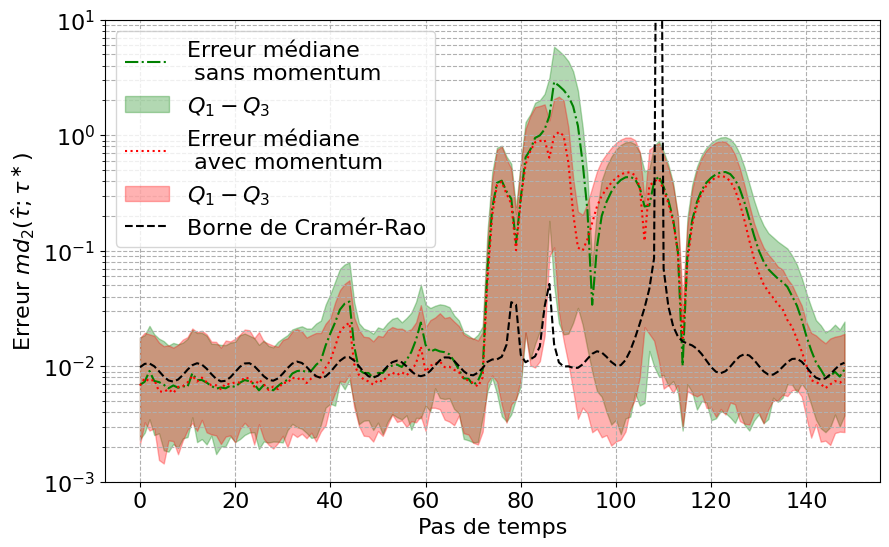

In [ ]:
# Calcul des erreurs moyennes et des écarts-types (on ignore le premier pas si nécessaire)
mean_errors_with = np.median(errors_with, axis=0)[1:]
q1_errors_with = np.percentile(errors_with, 25, axis=0)[1:]
q3_errors_with = np.percentile(errors_with, 75, axis=0)[1:]

mean_errors_without = np.median(errors_without, axis=0)[1:]
std_errors_without = np.std(errors_without, axis=0)[1:]
q1_errors_without = np.percentile(errors_without, 25, axis=0)[1:]
q3_errors_without = np.percentile(errors_without, 75, axis=0)[1:]

# Calcul de la borne de Cramér-Rao (CRB) pour chaque pas de temps
#crb_values = compute_crb_values(theta_star_sequence, snr_db)[1:]
crb_values = compute_crb_tau_values(theta_star_sequence, snr_db)[1:]

# Tracé des résultats
plt.figure(figsize=(10, 6))

# Courbe sans momentum
plt.plot(mean_errors_without, label="Erreur médiane \n sans momentum", color='green', linestyle='-.')
plt.fill_between(np.arange(time_steps)[:-1], mean_errors_without - q1_errors_without,
                 mean_errors_without + q3_errors_without, color='green', alpha=0.3,
                 label=r"$Q_1 - Q_3$")

# Courbe avec momentum
plt.plot(mean_errors_with, label="Erreur médiane \n avec momentum", color='red', linestyle=':')
plt.fill_between(np.arange(time_steps)[:-1], mean_errors_with - q1_errors_with,
                 mean_errors_with + q3_errors_with, color='red', alpha=0.3,
                 label=r"$Q_1 - Q_3$")

# Borne de Cramér-Rao
plt.plot(crb_values, '--', label="Borne de Cramér-Rao", color="black")


plt.xlabel("Pas de temps", fontsize=16)
#plt.ylabel(r"Erreur $md_2(\hat{\theta};\theta^\ast)$", fontsize=16)
plt.ylabel(r"Erreur $md_2(\hat{\tau};\tau^\ast)$", fontsize=16)
#plt.title("Comparaison des performances avec et sans momentum sur {} expériences".format(num_experiments))
plt.yscale("log")  # Échelle logarithmique sur l'axe des ordonnées
plt.ylim(1e-3,10)
plt.legend()
plt.grid(True, which="both", linestyle="--")

# Modification
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Save the figure as a PDF
pdf_filename = "content/DMPGDvDPGD.pdf"
plt.savefig(pdf_filename, format="pdf")
plt.show()